In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from skimage.color import rgb2lab
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
!pip install deltae
import deltae
!pip install scikit-image
from skimage import color

In [ ]:
#these are always the same
xyzbar = np.array(pd.read_excel('XYZ.xlsx',usecols='C:E'))
E = np.array(pd.read_excel('XYZ.xlsx',usecols='B'))

data = np.array(pd.read_excel('cmyk-10nm.xlsx', usecols='A:L'))
wavelength = data[:,0]

#you could add any colors that you have
cyan = data[:,2]
magenta = data[:,3]
green = data[:,4]
blue = data[:,5]
black = data[:,6]
red_petg= data[:,8]
blue_pla = data[:,9]
cream = data[:,10]
slime = data[0,11]



#purple PLA
target = data[:,7]

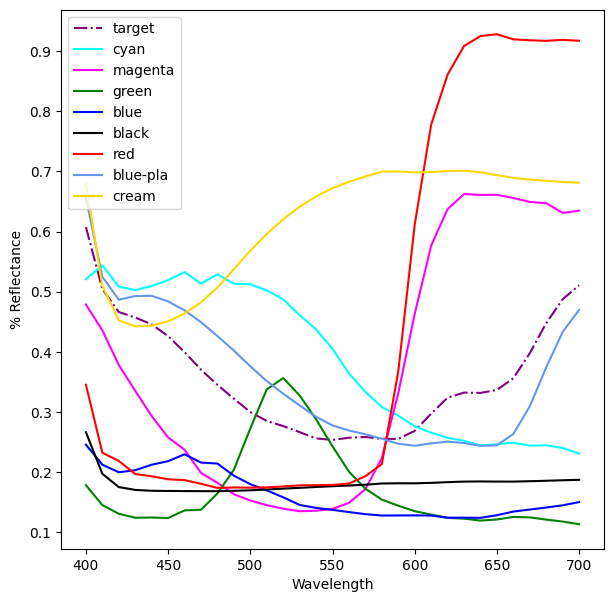

In [8]:
x = wavelength

plt.figure(figsize=(7, 7))
plt.plot(x, target, 'purple', label='target', linestyle= '-.', markersize='7')
plt.plot(x, cyan, 'cyan', label='cyan', markersize='7')
plt.plot(x, magenta, 'magenta', label='magenta', markersize='7')
plt.plot(x, green, 'green', label='green', markersize='7')
plt.plot(x, blue, 'blue', label='blue', markersize='7')
plt.plot(x, black, 'black', label='black', markersize='7')
plt.plot(x, red_petg, 'red', label='red', markersize='7')
plt.plot(x, blue_pla, '#6495ED', label='blue-pla', markersize='7')
plt.plot(x, cream, 'gold', label='cream', markersize='7')


plt.xlabel('Wavelength')
plt.ylabel('% Reflectance')
#plt.title('Reflectance of Samples Before Interpolation')
plt.legend(loc='best')
plt.grid(False)
plt.legend()
plt.show()

The function below takes **reflectance data** and calculates the CIE LAB values for a reflectance curve.

In [9]:
def ref2lab(R):
    xyzbar = np.array(pd.read_excel('XYZ.xlsx', usecols='C:E'))
    E = np.array(pd.read_excel('XYZ.xlsx', usecols='B')).flatten()

    xbar, ybar, zbar = xyzbar.T

    # Normalize the illuminant power
    K = 100 / np.dot(E, ybar)
    Xn, Yn, Zn = K * np.dot(E, xbar), K * np.dot(E, ybar), K * np.dot(E, zbar)
    X, Y, Z = K * np.dot(E * R, xbar), K * np.dot(E * R, ybar), K * np.dot(E * R, zbar)


    def f(t):
        delta = 6/29
        return np.where(t > delta**3, np.cbrt(t), t / (3 * delta**2) + 4/29)


    L = 116 * f(Y / Yn) - 16
    a = 500 * (f(X / Xn) - f(Y / Yn))
    b = 200 * (f(Y / Yn) - f(Z / Zn))

    return np.array([L, a, b])

In [12]:
#test
print(f'L*, a*, b* for the target: {ref2lab(target)}')

L*, a*, b* for the target: [ 60.13395119   9.81081371 -17.55119574]


L* (60.13): This value represents the lightness of the color, where 0 is black and 100 is white. A value of around 60 indicates a moderate lightness, which is typical for many colors.

a* (9.81): This value indicates the position between red and green. Positive values signify red/magenta, while negative values signify green. A positive value of around 9.81 suggests a shift towards red/magenta, which aligns with purple hues.

b* (-17.55): This value indicates the position between yellow and blue. Negative values signify blue, while positive values signify yellow. A negative value of around -17.55 indicates a shift towards blue, further supporting the purple hue.

In [13]:
def rgb_to_lab(R, G, B):
    """
    Convert an RGB color to CIE L*a*b* color space.

    Parameters:
    - R, G, B: Red, Green, and Blue components of the color.
               Expected range for each component: [0, 255].

    Returns:
    - A numpy array containing the L*, a*, and b* components of the color.
    """
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([R / 255.0, G / 255.0, B / 255.0]).reshape(1, 1, 3)

    # Convert to CIE L*a*b*
    lab_color = color.rgb2lab(rgb_normalized)
    # Reshape the result for easy reading
    return lab_color.reshape(-1)

The function "cal_delta_e" uses LAB values of te target and the reconstructed curve. It then calculates the Delta E 2000, which is a measure of the difference between the target samples and a reconstructed sample.

In [14]:
def cal_delta_e(lab1, lab2):
  #The library requires the Lab to be in a dictionary format
  lab1_dict = {'L': lab1[0], 'a': lab1[1], 'b': lab1[2]}
  lab2_dict = {'L': lab2[0], 'a': lab2[1], 'b': lab2[2]}

  deltaE = deltae.delta_e_2000(lab1_dict, lab2_dict)
  deltaE = np.nan_to_num(deltaE, nan=0)
  deltaE_mean=(np.mean(deltaE))

  return np.round(deltaE_mean,5)

In [15]:
def weighted_rms(predicted_spectrum, target_spectrum, weights):
    """
    Calculate the weighted Root Mean Square error between two spectra.

    Parameters:
    - predicted_spectrum: Predicted spectral values from the color mix.
    - target_spectrum: Target spectral values to be matched.
    - weights: Array of weights corresponding to the importance of each wavelength.

    Returns:
    - Weighted RMS error.
    """
    differences = predicted_spectrum - target_spectrum
    squared_differences = differences ** 2
    weighted_squared_differences = squared_differences * weights
    return np.sqrt(np.mean(weighted_squared_differences))

In [16]:
def objective_function(concentrations, target_spectrum, target_lab, colorant_spectra, weights, rms_weight, delta_e_weight):
    """
    Calculate a weighted combination of RMS and Delta E errors to find the best colorant mix.

    Parameters:
    - concentrations: Proportions of each colorant.
    - target_spectrum: Target spectral data to match.
    - target_lab: Target Lab color values for ΔE calculation.
    - colorant_spectra: Spectral data for each colorant.
    - weights: Weights for each wavelength.
    - rms_weight: The relative importance of the RMS error.
    - delta_e_weight: The relative importance of the Delta E error.

    Returns:
    - Combined objective value.
    """
    # Calculate the predicted spectrum
    predicted_spectrum = np.dot(concentrations, colorant_spectra)

    # Calculate weighted RMS error
    rms_error = weighted_rms(predicted_spectrum, target_spectrum, weights)

    # Calculate Lab values and Delta E
    predicted_lab = ref2lab(predicted_spectrum)
    delta_e_error = cal_delta_e(predicted_lab, target_lab)

    # Combine errors into a single objective value
    return rms_weight * rms_error + delta_e_weight * delta_e_error


In [18]:
# Define weights based on critical wavelength regions
wavelengths = wavelength
weights = np.ones_like(wavelengths)
weights[(wavelengths >= 400) & (wavelengths <= 450)] += 15
weights[(wavelengths > 450) & (wavelengths <= 550)] -= 0.25
weights[(wavelengths >= 600) & (wavelengths <= 700)] *= 1.5

# Define initial concentrations and bounds
initial_concentrations = np.array([ 0.23, 0.13,0.02, 0.08, 0.15,0.3,0.07, 0.04])
colorant_spectra = np.array([ cyan, magenta, green, blue, black, red_petg, blue_pla, cream])
#initial_concentrations = np.array([0.1] * len(colorant_spectra))
bounds = [(0, 1) for _ in initial_concentrations]

target_lab = ref2lab(target)



# Optimize using minimize from scipy.optimize

result = minimize(
    objective_function,
    initial_concentrations,
    args=(target, target_lab, colorant_spectra, weights, 0.1, 0.9),
    method='L-BFGS-B',
    bounds=bounds
)

# Output the result
if result.success:
    optimized_concentrations = result.x
    print("Optimized Concentrations:", np.round(optimized_concentrations,4))
else:
    print("Optimization failed:", result.message)


Optimized Concentrations: [2.000e-04 2.081e-01 0.000e+00 8.650e-02 1.044e-01 2.700e-03 6.686e-01
 0.000e+00]


In [19]:
optimized_concentrations = np.array([ optimized_concentrations[0], optimized_concentrations[1],optimized_concentrations[2],optimized_concentrations[3],
                                     optimized_concentrations[4],optimized_concentrations[5], optimized_concentrations[6],optimized_concentrations[7]])

In [20]:
reconstructed_spectrum = np.dot(colorant_spectra.T, optimized_concentrations)

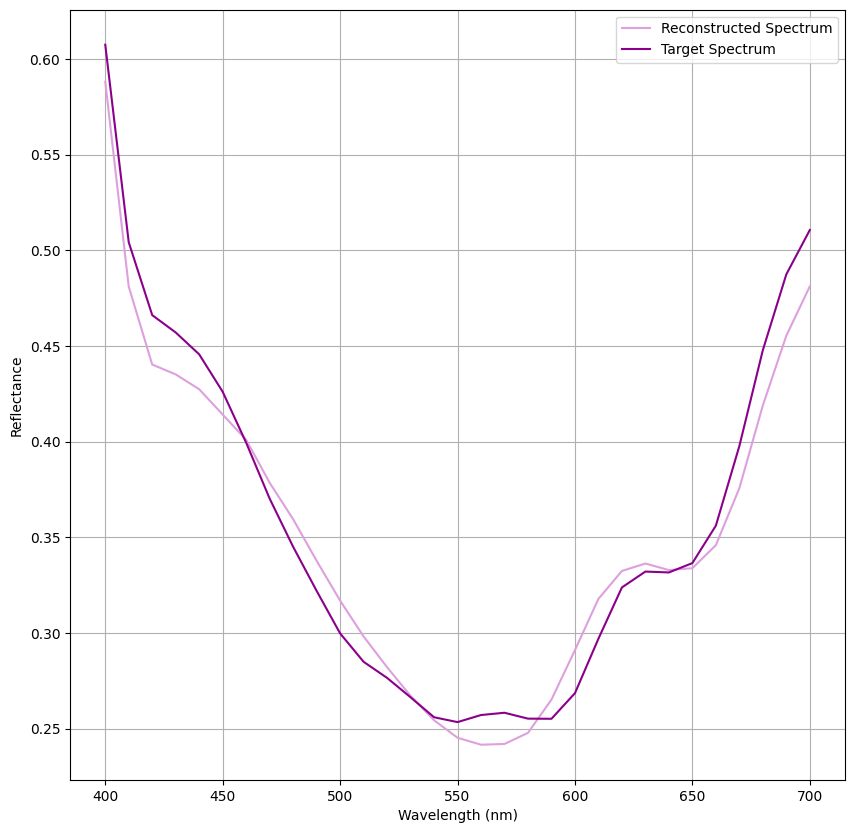

In [23]:
plt.figure(figsize=(10,10))
plt.plot(wavelengths, reconstructed_spectrum,color='plum', label='Reconstructed Spectrum')
plt.plot(wavelengths, target , label='Target Spectrum',color='darkmagenta')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
#plt.title('Reconstructed Spectrum from Optimized Concentrations')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
rms_error = weighted_rms(reconstructed_spectrum, target, weights)
print(rms_error)

0.039584018515616465


In [25]:
delta_error = cal_delta_e(ref2lab(reconstructed_spectrum), ref2lab(target))
print(delta_error)

0.66524


In [26]:
total_amount = 200 # total amount of paint in grams

amounts = [total_amount * conc for conc in optimized_concentrations]
print(np.round(amounts,2))

[3.0000e-02 4.1610e+01 0.0000e+00 1.7310e+01 2.0890e+01 5.3000e-01
 1.3373e+02 1.0000e-02]
